In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class RBM(object):
    def __init__(self, vis_unit, hidd_unit,temps=np.array(1)):
        self.vis_unit = vis_unit
        self.hidd_unit = hidd_unit
        self.temps=temps 
        #Initialise the parameters
        self.W = np.random.rand(self.vis_unit, self.hidd_unit)
        
        self.W_mask = []
        for i in np.arange(self.hidd_unit):
            n1 = np.random.randint(20,40)
            a = np.zeros(self.vis_unit)
            a[:n1] = 1
            np.random.shuffle(a)
            self.W_mask.append(a)
        self.W_mask = np.array(self.W_mask).T
        self.W_mask=(self.W_mask==1)
        print(self.W_mask.shape)
        print(self.W.shape)
        self.W=0.01*self.W_mask
            
        #MCMC chains
        self.chain_vis=np.random.binomial(1,0.5,vis_unit).reshape(vis_unit,1)
        self.p_v=self.chain_vis
        
        self.chain_hid=np.random.binomial(1,0.5,hidd_unit).reshape(hidd_unit,1)
        self.p_h=self.chain_hid
        self.n_samples=0
################################################ Updating Parameters ##########################################        
    
    def rbm_update_ps(self): #one sample at a time, MCMC by backward and forward pass
        hid=self.forward_pass(self.chain_vis)
        self.chain_hid=hid
        vis=self.backward_pass(hid)
        self.chain_vis=vis
        self.p_v_chain=(self.p_v*(self.n_samples)+self.chain_vis)/(self.n_samples+1)
        self.p_h_chain=(self.p_h*(self.n_samples)+self.chain_hid)/(self.n_samples+1)
        self.n_samples+=1
            
    
    #Derivative of the log probability
    def VH(self, vis,hid):
        shvd= np.tensordot(vis,hid.T,axes=1)
        return shvd
        
   
    # Upgrade the gradient     
    def W_Update(self, vis):
        #Positive phase
        hid=self.forward_pass(vis)
        der_W1 =self.VH(vis,hid) 
            
        #Negative phase
        vis_r = self.reconstruction(self.CD_k, vis)
        hid_r= self.forward_pass(vis_r)
        der_W2 = self.VH(vis_r,hid_r) 
        der_W=-der_W2+der_W1
        #der_W=der_W/np.sqrt(np.sum(der_W**2)/(self.hidd_unit*self.vis_unit))
        
        #Updating the parameters
        #self.W = self.W + self.learning_rate*der_W/vis.shape[1]
        self.W[self.W_mask] = self.W[self.W_mask] + self.learning_rate*der_W[self.W_mask]/vis.shape[1]
        
    def W_Update_Chain(self,vis):
        hid=self.forward_pass(vis)
        der_W1 =self.VH(vis,hid)/vis.shape[1]
        
        #model
        self.rbm_update_ps()
        der_W2=self.VH((2*self.p_v_chain-1),(2*self.p_h_chain-1))
        der_W=-der_W2+der_W1
        #der_W=der_W/np.sqrt(np.sum(der_W**2)/(self.hidd_unit*self.vis_unit))
        
        #Updatinf the parameters
        self.W = self.W + self.learning_rate*der_W
         
    
    def W_Update2(self, vis):
        #Positive phase
        X = np.tensordot(self.W.T, vis, axes=1)
        p_h = 1.0/(1.0+np.exp(-2*X))
        der_W1 =self.VH(vis,2*p_h-1) 
            
        #Negative phase
        vis_r = self.reconstruction(self.CD_k, vis)
        X = np.tensordot(self.W.T, vis_r, axes=1)
        p_h = 1.0/(1.0+np.exp(-2*X))
        der_W2 = self.VH(vis_r,2*p_h-1) 
        der_W=-der_W2+der_W1
        #der_W=der_W/np.sqrt(np.sum(der_W**2)/(self.hidd_unit*self.vis_unit))
        
        #Updating the parameters
        self.W = self.W + self.learning_rate*der_W/vis.shape[1]
        #self.W[self.W_mask] = self.W[self.W_mask] + self.learning_rate*der_W[self.W_mask]/vis.shape[1] 
        
########################################### Reconstruction ####################################################       
        
     #Calculate the hidden states 
    def forward_pass(self, vis):
        X = np.tensordot(self.W.T, vis, axes=1)
        p_h = 1.0/(1.0+np.exp(-2*X))
        hid  = 2*(p_h>np.random.rand(self.hidd_unit, vis.shape[1]))-1
        return hid            
            
    # Reconstruct the visible states   
    def backward_pass(self, hid):
        X = np.tensordot(self.W,hid,axes=1)
        p_v = 1.0/(1.0+np.exp(-2*X))
        v_r = 2*(p_v>np.random.rand(self.vis_unit,hid.shape[1]))-1
        return v_r
            
    # Perform Gibbs Sampling
    def reconstruction(self, steps, vis):
        vis_r=vis
        for i in np.arange(steps):
            hid = self.forward_pass(vis_r)
            vis_r = self.backward_pass(hid)
        return vis_r
    
############################################# Training ########################################################

    #Training Model    
    def learn(self, training_data, test_data, learning_rate=0.01, epochs=10, batch_size=1, CD_k=1):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.CD_k = CD_k
        
        num_batches = int(training_data.shape[0]/self.batch_size)
        self.error_history=np.zeros(self.epochs)
        vis_test = test_data.T
        
        for k in np.arange(self.epochs):
            
            error = 0
            for b in np.arange(0, num_batches):
                batch = training_data[int(b*self.batch_size):int((b+1)*self.batch_size)]
                vis=batch.T
                self.W_Update(vis)
                samples = self.reconstruction(1, vis_test)
                error += 0.25*np.sum((vis_test - samples)**2)/np.prod(vis_test.shape)
            error=error/num_batches
            self.error_history[k]=error
            
            print('Epoch:%d,Training error:%f'%(k, error))


In [4]:
training_data = np.loadtxt('filename.txt')

In [5]:
training_data.shape

(1000000,)

In [6]:
data = training_data.reshape(10000,100)

In [7]:
new_data = data[1000:,:]

In [8]:
new_data.shape

(9000, 100)

In [9]:
new_data_train = new_data[:8000]

In [10]:
new_data_train.shape

(8000, 100)

In [11]:
new_data_test = new_data[8000:]

In [12]:
new_data_test.shape

(1000, 100)

In [132]:
rbm = RBM(vis_unit = 100, hidd_unit=80)
model = rbm.learn(training_data=new_data_train,test_data=new_data_test, learning_rate=0.01,epochs=100, CD_k=2, batch_size=50)

(100, 80)
(100, 80)
Epoch:0,Training error:0.434634
Epoch:1,Training error:0.304491
Epoch:2,Training error:0.234234
Epoch:3,Training error:0.193150
Epoch:4,Training error:0.168102
Epoch:5,Training error:0.152242
Epoch:6,Training error:0.141172
Epoch:7,Training error:0.132704
Epoch:8,Training error:0.125566
Epoch:9,Training error:0.120523
Epoch:10,Training error:0.115606
Epoch:11,Training error:0.111950
Epoch:12,Training error:0.108450
Epoch:13,Training error:0.105592
Epoch:14,Training error:0.103078
Epoch:15,Training error:0.100688
Epoch:16,Training error:0.098606
Epoch:17,Training error:0.096992
Epoch:18,Training error:0.095127
Epoch:19,Training error:0.093571
Epoch:20,Training error:0.092167
Epoch:21,Training error:0.090552
Epoch:22,Training error:0.089428
Epoch:23,Training error:0.088495
Epoch:24,Training error:0.087382
Epoch:25,Training error:0.086601
Epoch:26,Training error:0.085639
Epoch:27,Training error:0.084637
Epoch:28,Training error:0.083526
Epoch:29,Training error:0.082818


Text(0, 0.5, 'error')

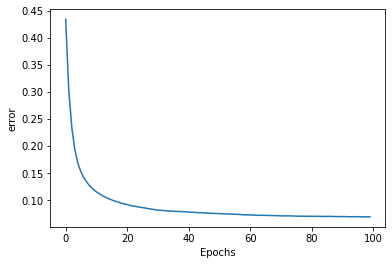

In [133]:
plt.plot(np.arange(100), rbm.error_history)
plt.xlabel("Epochs")
plt.ylabel("error")

In [134]:
def energy_ising_1d(configuration,J,h):
    num_spins = len(configuration)
    energy = 0.0
    for i in range(num_spins):
        spini = configuration[i]
        #set the value of spin i+1, make sure to test if i+1<num_spins, and otherwise account for periodic boundaries
        #you can do this with an if statement if you have to
        ip1 = (i+1)%num_spins
        spinip1 = configuration[ip1]
        
        energy = energy - J * (spini * spinip1) - h*spini
        
    return energy

def energy_batch(configs,J,h):
    energies = np.array([energy_ising_1d(config,J,h) for config in configs])
    
    return energies

def avg_energy(configs,J,h):
    return np.mean(energy_batch(configs,J,h))

In [135]:
recons_array = rbm.reconstruction(5, new_data_train.T)
recons_energy =  energy_batch(recons_array.T,J=1,h=0)

data_energy_train = energy_batch(new_data_train,J=1,h=0)
data_energy_test = energy_batch(new_data_test,J=1,h=0)

mean_data_train = np.mean(data_energy_train)
mean_data_test = np.mean(data_energy_test)
mean_recons = np.mean(recons_energy)

print('mean_data_train:',mean_data_train)
print('mean_data_test:',mean_data_test)
print('mean_recons:',mean_recons)

std_data_train = np.std(data_energy_train)
std_data_test = np.std(data_energy_test)
std_recons = np.std(recons_energy)

print('std_data_train:',std_data_train)
print('std_data_test:',std_data_test)
print('std_recons:',std_recons)

mean_data_train: -75.936
mean_data_test: -76.356
mean_recons: -74.7545
std_data_train: 6.2212461774149395
std_data_test: 6.275130596250567
std_recons: 6.769544279344068


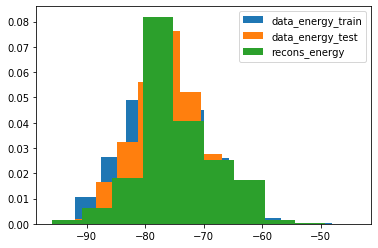

In [136]:
plt.hist(data_energy_train, label='data_energy_train', density=True)
plt.hist(data_energy_test, label='data_energy_test', density=True)
plt.hist(recons_energy, label='recons_energy', density=True)
plt.legend()

In [137]:
model = rbm.learn(training_data=new_data_train,test_data=new_data_test, learning_rate=0.01,epochs=600, CD_k=2, batch_size=50)

Epoch:0,Training error:0.069401
Epoch:1,Training error:0.069190
Epoch:2,Training error:0.069318
Epoch:3,Training error:0.069272
Epoch:4,Training error:0.068950
Epoch:5,Training error:0.069005
Epoch:6,Training error:0.068920
Epoch:7,Training error:0.068938
Epoch:8,Training error:0.069003
Epoch:9,Training error:0.068866
Epoch:10,Training error:0.068843
Epoch:11,Training error:0.068606
Epoch:12,Training error:0.068662
Epoch:13,Training error:0.068775
Epoch:14,Training error:0.068814
Epoch:15,Training error:0.068762
Epoch:16,Training error:0.068534
Epoch:17,Training error:0.068482
Epoch:18,Training error:0.068467
Epoch:19,Training error:0.068471
Epoch:20,Training error:0.068370
Epoch:21,Training error:0.068354
Epoch:22,Training error:0.068275
Epoch:23,Training error:0.068160
Epoch:24,Training error:0.068032
Epoch:25,Training error:0.068093
Epoch:26,Training error:0.068182
Epoch:27,Training error:0.067955
Epoch:28,Training error:0.067997
Epoch:29,Training error:0.068025
Epoch:30,Training er

Epoch:245,Training error:0.064938
Epoch:246,Training error:0.064838
Epoch:247,Training error:0.064919
Epoch:248,Training error:0.065023
Epoch:249,Training error:0.064886
Epoch:250,Training error:0.064927
Epoch:251,Training error:0.064912
Epoch:252,Training error:0.064799
Epoch:253,Training error:0.064749
Epoch:254,Training error:0.064864
Epoch:255,Training error:0.064805
Epoch:256,Training error:0.064797
Epoch:257,Training error:0.064749
Epoch:258,Training error:0.064812
Epoch:259,Training error:0.064783
Epoch:260,Training error:0.064978
Epoch:261,Training error:0.064883
Epoch:262,Training error:0.064827
Epoch:263,Training error:0.064648
Epoch:264,Training error:0.064947
Epoch:265,Training error:0.064688
Epoch:266,Training error:0.064671
Epoch:267,Training error:0.064737
Epoch:268,Training error:0.064798
Epoch:269,Training error:0.064642
Epoch:270,Training error:0.064469
Epoch:271,Training error:0.064462
Epoch:272,Training error:0.064452
Epoch:273,Training error:0.064641
Epoch:274,Trai

Epoch:486,Training error:0.063330
Epoch:487,Training error:0.063228
Epoch:488,Training error:0.063179
Epoch:489,Training error:0.063352
Epoch:490,Training error:0.063485
Epoch:491,Training error:0.063321
Epoch:492,Training error:0.063254
Epoch:493,Training error:0.063112
Epoch:494,Training error:0.063085
Epoch:495,Training error:0.063080
Epoch:496,Training error:0.063356
Epoch:497,Training error:0.063238
Epoch:498,Training error:0.063117
Epoch:499,Training error:0.063198
Epoch:500,Training error:0.063311
Epoch:501,Training error:0.063350
Epoch:502,Training error:0.063313
Epoch:503,Training error:0.063278
Epoch:504,Training error:0.063190
Epoch:505,Training error:0.063187
Epoch:506,Training error:0.063091
Epoch:507,Training error:0.063035
Epoch:508,Training error:0.063002
Epoch:509,Training error:0.063037
Epoch:510,Training error:0.062961
Epoch:511,Training error:0.063188
Epoch:512,Training error:0.063319
Epoch:513,Training error:0.063342
Epoch:514,Training error:0.063216
Epoch:515,Trai

Text(0, 0.5, 'error')

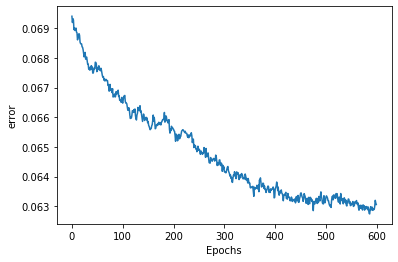

In [138]:
plt.plot(np.arange(600), rbm.error_history)
plt.xlabel("Epochs")
plt.ylabel("error")

In [139]:
energy_data  = energy_batch(new_data_train, J=1, h=1)

In [140]:
energy_data.size

8000

In [141]:
M = np.tile(energy_data,(energy_data.size,1))

In [142]:
M.shape

(8000, 8000)

In [143]:
M.T-M

array([[  0.,   6.,  -2., ...,  -6.,  -8., -10.],
       [ -6.,   0.,  -8., ..., -12., -14., -16.],
       [  2.,   8.,   0., ...,  -4.,  -6.,  -8.],
       ...,
       [  6.,  12.,   4., ...,   0.,  -2.,  -4.],
       [  8.,  14.,   6., ...,   2.,   0.,  -2.],
       [ 10.,  16.,   8., ...,   4.,   2.,   0.]])

In [144]:
W_ij = rbm.W

In [145]:
W_ij.shape

(100, 80)

In [146]:
W_ij

array([[ 0.    ,  0.    ,  0.    , ...,  0.0044,  0.    ,  0.    ],
       [ 0.    , -0.0332,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.0624, ...,  0.    ,  0.    ,  0.    ],
       ...,
       [ 0.    ,  0.    ,  0.142 , ...,  0.2384, -0.1324, -0.094 ],
       [-0.002 ,  0.2948,  0.    , ...,  0.    , -0.242 ,  0.    ],
       [ 0.    ,  0.    ,  0.0416, ...,  0.    , -0.008 ,  0.    ]])

In [147]:
corr = np.corrcoef(W_ij.T)

In [148]:
corr[0]

array([ 1.00000000e+00,  5.11659735e-03,  6.73559159e-02, -2.02663003e-02,
       -7.59260114e-03,  7.53110757e-03,  2.63382041e-02,  7.60554599e-03,
        2.13468190e-02,  5.92726252e-02, -1.44954758e-02,  3.02841360e-02,
        4.75129745e-03,  4.87681947e-03, -6.25250546e-02, -3.09896059e-01,
        8.13737641e-02,  4.00335706e-03, -2.88779144e-02,  1.58148279e-02,
       -2.79724563e-02, -1.22128261e-01, -3.59284839e-02, -3.07578976e-02,
        3.77791734e-02,  2.80889534e-02,  3.04042394e-02,  2.62056510e-02,
        1.63482065e-02,  3.06865592e-02,  2.30129253e-02,  2.12708037e-02,
        2.15987100e-02, -1.52475242e-01, -3.28917602e-02,  1.19131237e-03,
        2.25730282e-02,  1.85278494e-02, -1.85704642e-02, -1.94421267e-02,
        8.50363036e-03, -4.61057391e-02,  1.86478507e-01,  2.14324529e-02,
       -1.03542450e-01, -1.44172445e-01, -1.68789109e-02,  1.99938733e-02,
       -2.28497148e-02, -6.69377933e-03, -4.67866212e-02,  5.23558160e-02,
        3.44913672e-02, -

In [149]:
random_w = np.random.randn(100, 50)

In [150]:
random_w

array([[-0.32974193, -1.04909943, -0.44800708, ..., -0.89701464,
        -0.37495837, -1.448701  ],
       [ 1.02383203, -0.95650429,  0.27360967, ..., -1.441449  ,
         0.2160616 ,  0.68661107],
       [-1.16516422,  1.28862169,  0.52298299, ...,  0.59280745,
         1.30410499, -0.67242848],
       ...,
       [ 0.54314623,  1.43656888,  0.72248831, ...,  0.25672054,
         0.51835177,  1.07533405],
       [ 0.89780305, -0.70252618,  0.98743365, ..., -1.66289783,
         1.2231888 , -0.30438547],
       [-0.13380863,  0.50051007, -1.64016161, ...,  0.19777542,
        -0.64280523,  0.14673906]])

In [151]:
corr_random_w = np.corrcoef(random_w)

In [152]:
corr_random_w

array([[ 1.        , -0.13942244, -0.13695312, ...,  0.0286112 ,
         0.09935914, -0.02576265],
       [-0.13942244,  1.        , -0.00827568, ..., -0.25263748,
        -0.07303922, -0.12173049],
       [-0.13695312, -0.00827568,  1.        , ...,  0.04136475,
        -0.07643286,  0.00882486],
       ...,
       [ 0.0286112 , -0.25263748,  0.04136475, ...,  1.        ,
         0.03472429, -0.06653617],
       [ 0.09935914, -0.07303922, -0.07643286, ...,  0.03472429,
         1.        ,  0.04472802],
       [-0.02576265, -0.12173049,  0.00882486, ..., -0.06653617,
         0.04472802,  1.        ]])

In [153]:
eigen_random_w = np.linalg.eig(corr_random_w)

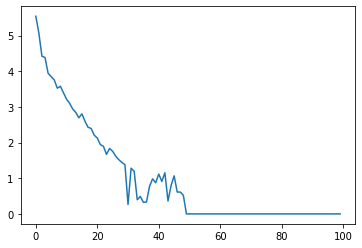

In [154]:
plt.plot(eigen_random_w[0])

In [155]:
eigen = np.linalg.eig(corr)

In [162]:
eigen[0]

array([2.61167051, 2.40029569, 2.24594231, 2.11259421, 2.06832837,
       2.01938961, 1.89811202, 1.87215154, 1.86288989, 1.8327233 ,
       1.77133355, 1.74721646, 1.72550091, 1.71316803, 1.66881721,
       1.64054777, 1.61945294, 0.01197496, 0.02774056, 1.56323042,
       0.04132702, 0.04904751, 1.54713917, 1.50473438, 0.07194035,
       0.07818729, 0.0894019 , 0.11148248, 0.12398639, 1.47601082,
       1.46357924, 0.1454633 , 0.16070324, 0.15453978, 0.19568293,
       1.41781077, 0.22610668, 1.41338251, 0.25437149, 0.2735294 ,
       1.38576061, 0.28817059, 0.31360501, 0.37161314, 1.34786823,
       0.40330359, 1.33268104, 1.318927  , 0.4478773 , 0.44467298,
       0.50465519, 1.26170625, 1.26557764, 0.53320569, 1.21401772,
       1.18234728, 0.57098149, 1.16454303, 1.16022794, 0.65118   ,
       0.63814146, 0.60751599, 0.74953104, 0.78051789, 0.72322305,
       0.81166532, 1.11326568, 0.61255953, 0.86410007, 0.91634806,
       1.10644365, 1.04283108, 0.94440268, 0.69915851, 1.09561

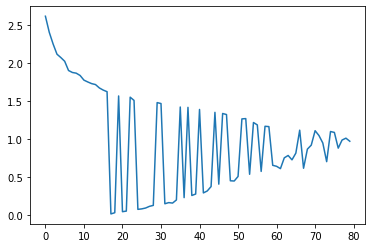

In [161]:
plt.plot(eigen[0])

Text(0.5, 0, 'data_energy')

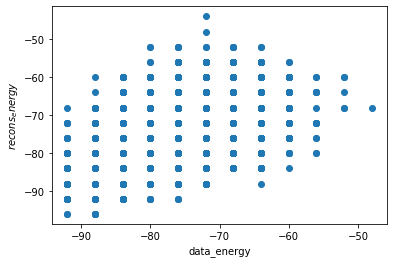

In [160]:
plt.scatter(data_energy_train, recons_energy)
plt.ylabel("$recons_energy$")
plt.xlabel("data_energy")

In [76]:
np.zeros(100)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [77]:
n1 =  np.random.randint(10,30)
a  = np.zeros(100)
a[:n1]=1

In [78]:
a

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [79]:
a.shape

(100,)

In [80]:
weights = []
for i in range(2):
    n1 =  np.random.randint(10,60)
    print(n1)
    a  = np.zeros(100)
    a[:n1] = 1
    weights.append(a)
    

24
42


In [81]:
weights

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

In [82]:
NV = []
n1 = np.random.randint(10,30)
a  = np.zeros(100)
a[:n1] = 1
NV.append(a)


In [83]:
NV

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]